# Demo: Cognitive Services - Vision
The purpose of this notebook is to showcase using MS Cognitive Services Vision API - both from the portal and leveraging the Python SDK
At the end of the demo, persons should be able to:
* Create a Cognitive serivice in the portal
* Use object detection on a corpus of images
* Quickly train a corpus of images for object detection via the web portal - customvision.api
* Access the trained model for predictions via the Python API
* Use the OCR text recognizer on a corpus of images

The scenario around this demo is as follows. Imagine driving through a booth which can determine the vehicle - type, color, and license plate for reasons such as creating a database for car rental services.

**Assumptions**
* A resource group for this project exists in your portal
* An azure storage blob with the images from the folder image/blobStorage exists on your account. You will require the blob key, container name and blob name for this lab.

## Step 1: Create Cognitive Service in portal.azure
1 key to rule them all!
For the MS services only one key is required to access all the services. 
1. Go to [portal.azure.com](https://portal.azure.com)
2. Navigate on the blade to **Create resource** --> **AI + Machine Learning** --> **Computer Vision**. 
   Enter the required info:
       - name for your service
       - subscription being used
       - where to deploy service 
       - pricing tier
       - resource group to associate with service
   <insert screenshot here>
3. Once the resource has been created, let's grab some info for our API calls. Navigate to **Overview** and note, the *Endpoint* and *Keys*


In [1]:
import time 
import requests
import cv2
import operator
import numpy as np
import os
from azure.storage.blob import BlockBlobService 
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from __future__ import print_function

# Import library to display results
import matplotlib.pyplot as plt
%matplotlib inline 
# Display images within Jupyter

In [2]:
# Variables
_region = '' #Here you enter the region of your subscription
_url = 'https://{}.api.cognitive.microsoft.com/vision/v2.0/analyze'.format(_region)
_key = '' #Here you have to paste your primary key from cognitive service
_blob_name = '' #Here you have to paste your blob name
_blob_key = '' #Here you have to paste your blob key
_container_name = '' #Here you have to paste your container name from storage
_maxNumRetries = 10
block_blob_service = BlockBlobService(_blob_name, _blob_key)

In [3]:
# Computer Vision parameters
params = { 'visualFeatures' : 'Color,Categories,Tags,Objects'} 
headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/octet-stream'

json = None

In [4]:
#helper functions
def processRequest( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json() ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'video' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json() ) )

        break
        
    return result

c:\python27\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


File: 4.jpg	 Object: car	 Confidence:0.754
[{u'confidence': 0.754, u'object': u'car', u'parent': {u'confidence': 0.76, u'object': u'Land vehicle', u'parent': {u'confidence': 0.761, u'object': u'Vehicle'}}, u'rectangle': {u'y': 61, u'x': 12, u'w': 187, u'h': 110}}]
File: 5.jpg	 Object: car	 Confidence:0.609
[{u'confidence': 0.609, u'object': u'car', u'parent': {u'confidence': 0.648, u'object': u'Land vehicle', u'parent': {u'confidence': 0.65, u'object': u'Vehicle'}}, u'rectangle': {u'y': 22, u'x': 37, u'w': 182, u'h': 112}}, {u'confidence': 0.551, u'object': u'hatchback', u'parent': {u'confidence': 0.814, u'object': u'car', u'parent': {u'confidence': 0.829, u'object': u'Land vehicle', u'parent': {u'confidence': 0.831, u'object': u'Vehicle'}}}, u'rectangle': {u'y': 15, u'x': 118, u'w': 160, u'h': 118}}]
File: 8.jpg	 Object: car	 Confidence:0.881
[{u'confidence': 0.881, u'object': u'car', u'parent': {u'confidence': 0.895, u'object': u'Land vehicle', u'parent': {u'confidence': 0.899, u'obj

IndexError: list index out of range

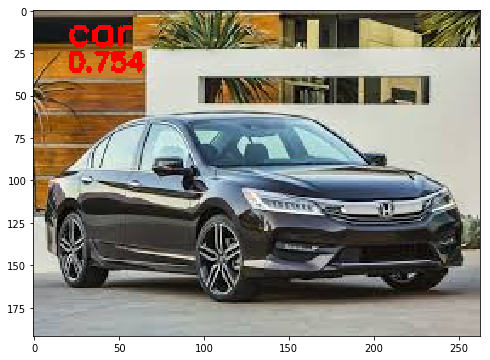

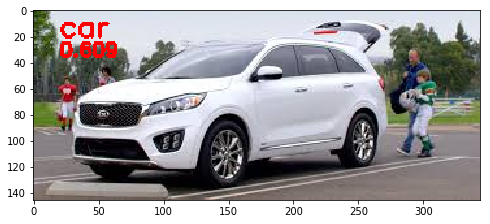

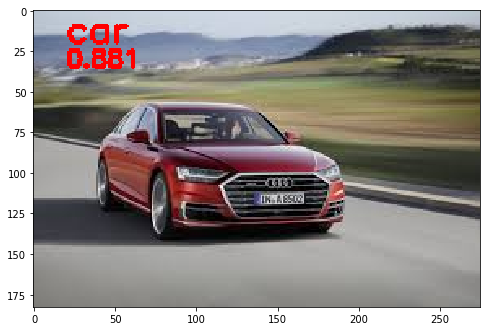

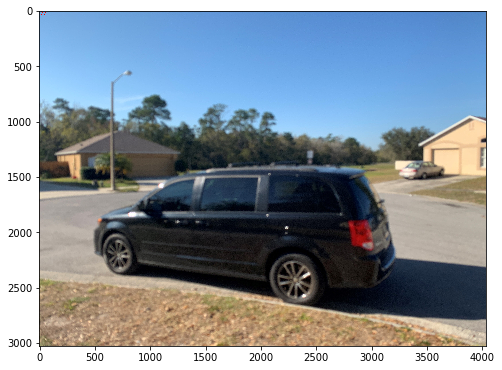

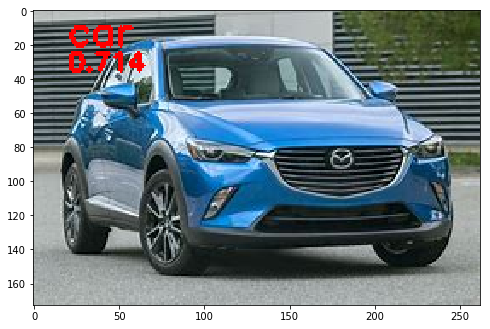

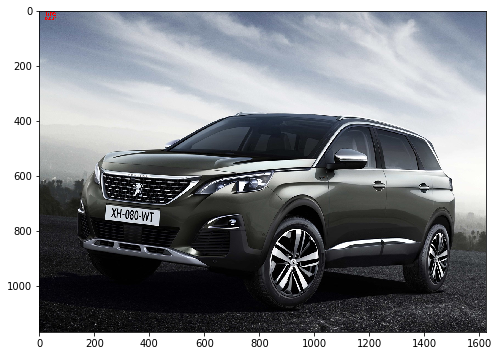

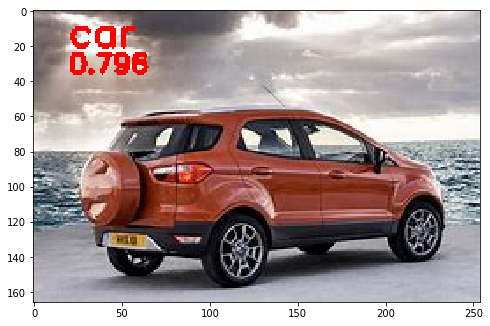

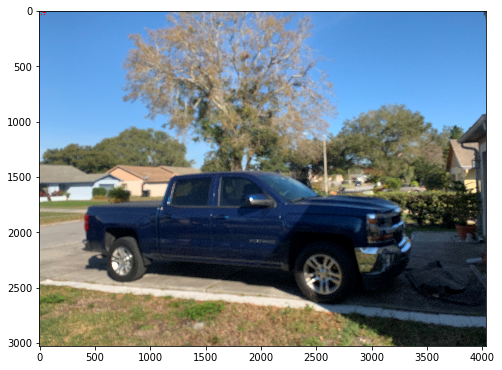

In [5]:
#open images from blob to an array
generator = block_blob_service.list_blobs(_container_name)
for ablob in generator:
    blob = block_blob_service.get_blob_to_bytes(_container_name, ablob.name)
    result = processRequest( json, blob.content, headers, params )
    if result is not None:
        # Load the original image, fetched from the URL
        data8uint = np.fromstring( blob.content, np.uint8 ) # Convert string to an unsigned int array
        img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )
        cv2.putText( img, result['objects'][0]['object'], (20,20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,0,0), 2 )
        cv2.putText( img, str(result['objects'][0]['confidence']), (20,35), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
        fig, ax = plt.subplots(figsize=(8, 11))
        print ('File: '+ ablob.name + '\t Object: '+result['objects'][0]['object'] +'\t Confidence:'+str(result['objects'][0]['confidence']))
        print (result['objects'])
        ax.imshow( img )

### Using the Custom API to determine vehicle type - minivan, truck, compact or SUV
* Sign in on [customvision.ai](https://customvision.ai) 
* Create a new project for object detection - use the data supplied in images/training
    - upload all the images to the project using the labels for each folder.
* Train model in the project
* Leverage the API to access the model created in the web interface

In [6]:
# Now there is a prediction endpoint (created from the web portal, but API also allows for the training process)
prediction_key = '' #Here you have to paste your predictive key from settings on customvision.ai
ENDPOINT = '' #Here you have to paste your endpoint
project_id = '' #Here you have to paste your projectid from the customvision.ai
iteration_id = '' #Here you paste the iteration from training
headers = {
    'Content-type': 'application/ocet-stream',
    'Ocp-Apim-Subscription-Key':'' #Here you paste from settings in customvision.ai
}
predictor = CustomVisionPredictionClient(prediction_key, endpoint=ENDPOINT)

for ablob in generator:
    blob = block_blob_service.get_blob_to_bytes(_container_name, ablob.name)
    results = predictor.predict_image(project_id, blob.content, iteration_id)
    pred= max(results.predictions, key=lambda x:x.probability).tag_name
    prob =  max(results.predictions, key=lambda x:x.probability).probability
    print ('File: '+ ablob.name  + '\t Object: '+ pred +'\t Confidence:'+ str(prob))


File: 4.jpg	 Object: compact	 Confidence:0.9792635
File: 5.jpg	 Object: suv	 Confidence:0.875035644
File: 8.jpg	 Object: compact	 Confidence:0.9730829
File: minivan1.jpg	 Object: minivan	 Confidence:0.7208733
File: suv.jpg	 Object: suv	 Confidence:0.9563232
File: suv2.jpg	 Object: truck	 Confidence:0.7515878
File: suv3.jpg	 Object: minivan	 Confidence:0.805384457
File: truck.jpg	 Object: truck	 Confidence:0.7256721
File: truck2.jpg	 Object: truck	 Confidence:0.9839213


### Using OCR API
* Read license plate

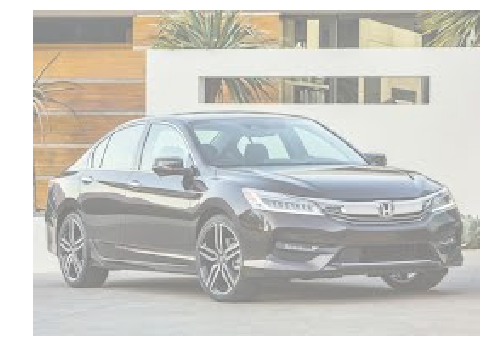

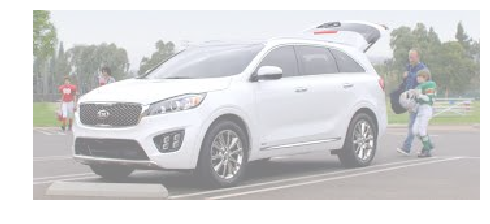

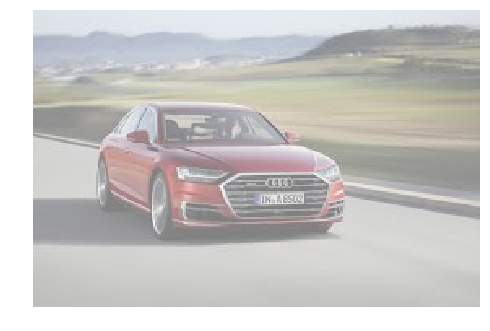

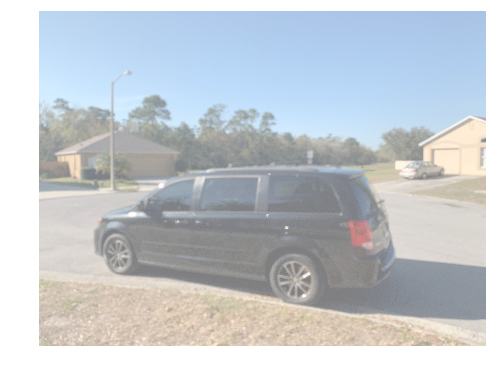

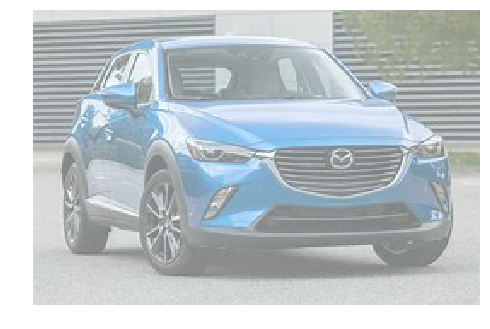

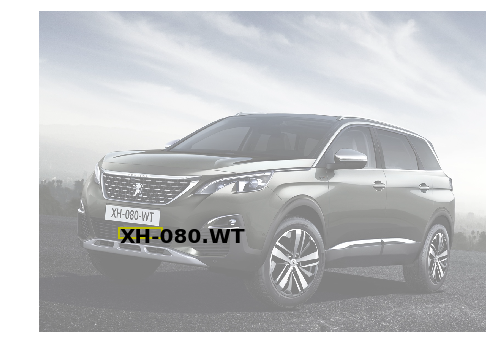

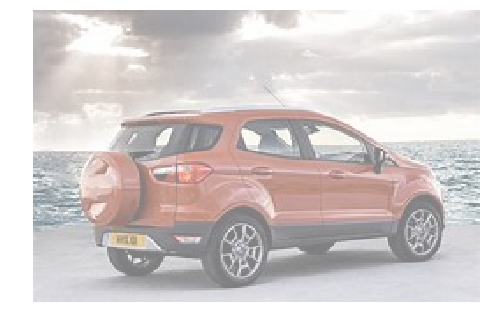

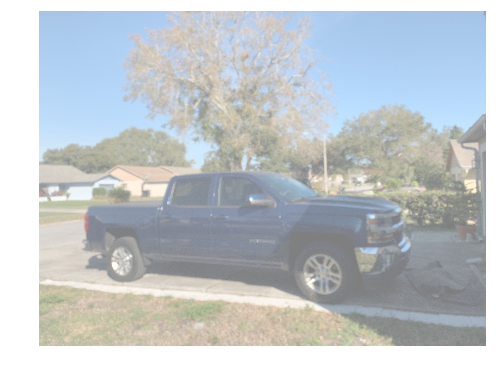

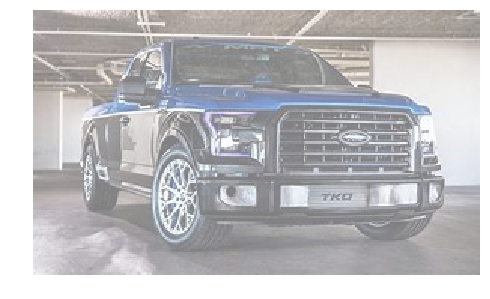

In [7]:
from matplotlib.patches import Rectangle
from PIL import Image
from io import BytesIO

ocr_url = 'https://{}.api.cognitive.microsoft.com/vision/v2.0/ocr'.format(_region)
headers = {'Ocp-Apim-Subscription-Key': _key}
params  = {'language': 'en', 'detectOrientation': 'false'}

for ablob in generator:
    blob_url = "https://" + _blob_name + '.blob.core.windows.net/' + _container_name + '/' + ablob.name
    data    = {'url': blob_url}

    response = requests.post(ocr_url, headers=headers, params=params, json=data)
    response.raise_for_status()

    analysis = response.json()

    # Extract the word bounding boxes and text.
    line_infos = [region["lines"] for region in analysis["regions"]]
    word_infos = []
    for line in line_infos:
        for word_metadata in line:
            for word_info in word_metadata["words"]:
                word_infos.append(word_info)
    word_infos
    # Display the image and overlay it with the extracted text.
    plt.figure(figsize=(8, 11))
    image = Image.open(BytesIO(requests.get(blob_url).content))
    ax = plt.imshow(image, alpha=0.5)
    for word in word_infos:
        bbox = [int(num) for num in word["boundingBox"].split(",")]
        text = word["text"]
        origin = (bbox[0], bbox[1])
        patch  = Rectangle(origin, bbox[2], bbox[3], fill=False, linewidth=2, color='y')
        ax.axes.add_patch(patch)
        plt.text(origin[0], origin[1], text, fontsize=20, weight="bold", va="top")
    plt.axis("off")